<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/MML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os

# Upload ZIP file
uploaded = files.upload()

# Extract ZIP file
zip_file = list(uploaded.keys())[0]  # Get the uploaded file name
zip_folder_name = zip_file.replace('.zip', '')

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(zip_folder_name)

# Get the path of the extracted folder
folder_path = os.path.join(os.getcwd(), zip_folder_name)
print("Folder extracted to:", folder_path)


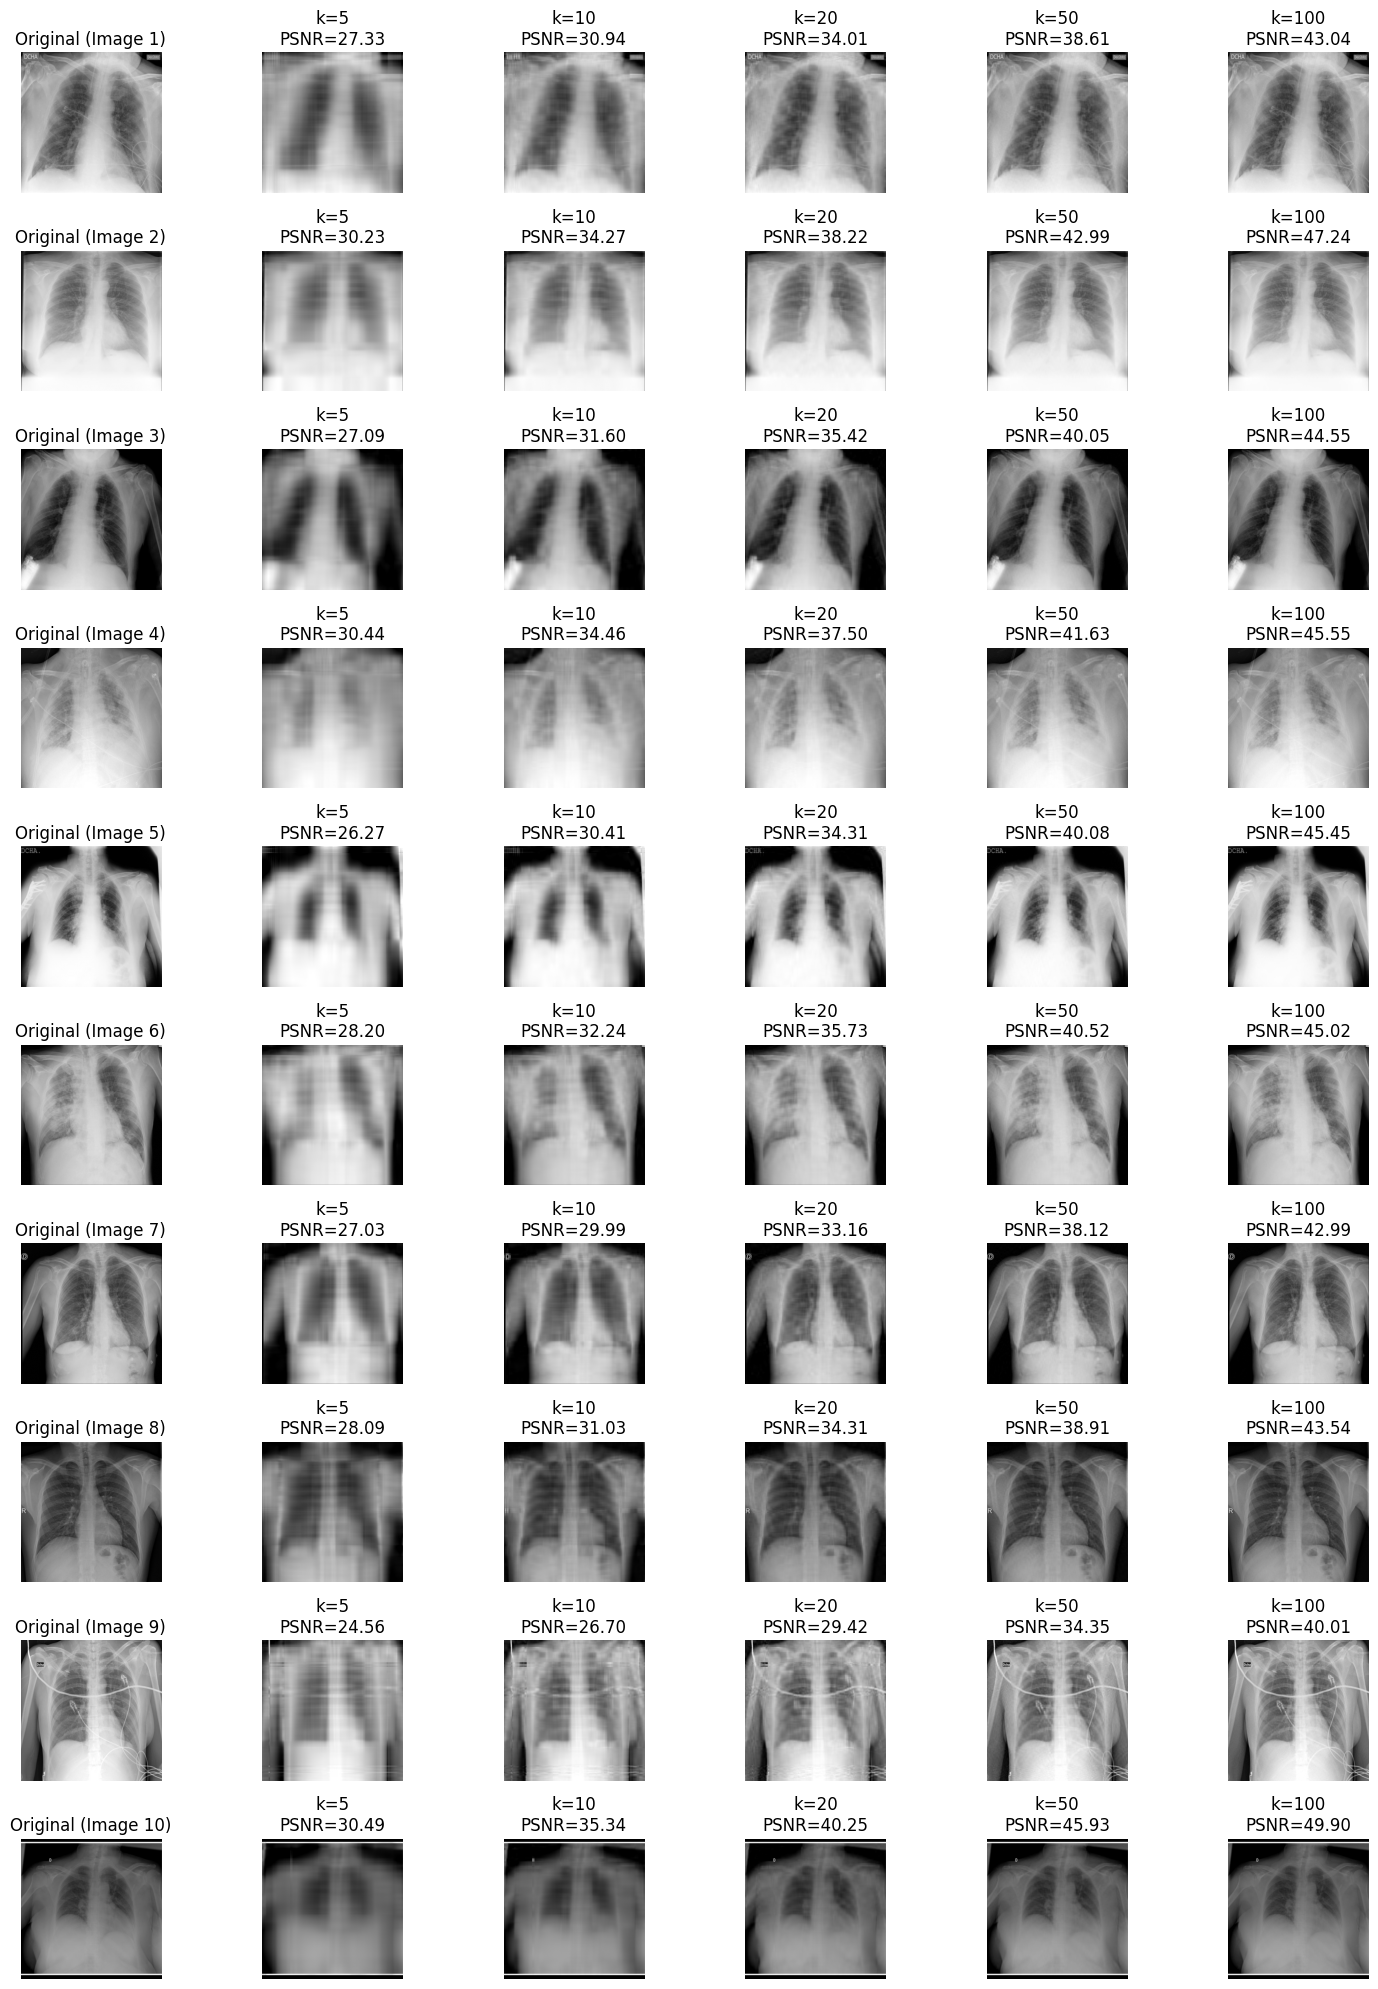

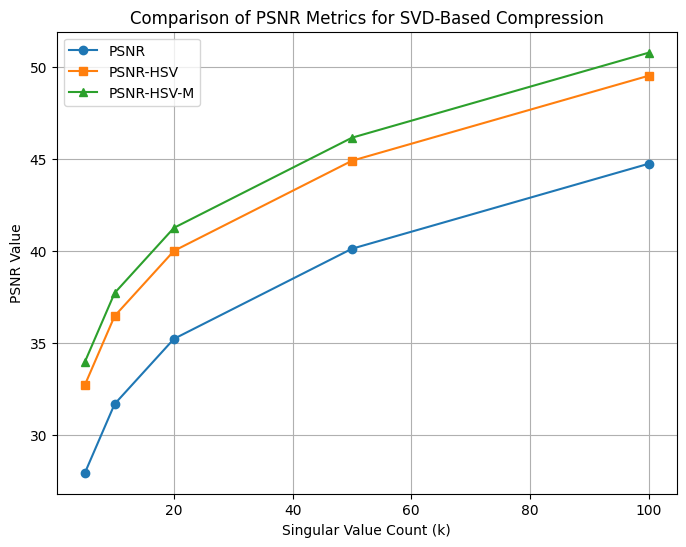

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import mean_squared_error

def compute_psnr(original, compressed):
    mse = mean_squared_error(original, compressed)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

def compute_psnr_hsv(original, compressed):
    original_hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV).astype(np.float32)
    compressed_hsv = cv2.cvtColor(compressed, cv2.COLOR_BGR2HSV).astype(np.float32)
    mse = np.mean((original_hsv - compressed_hsv) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

def compute_psnr_hsv_m(original, compressed):
    original_hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV).astype(np.float32)
    compressed_hsv = cv2.cvtColor(compressed, cv2.COLOR_BGR2HSV).astype(np.float32)
    mse_h = mean_squared_error(original_hsv[:, :, 0], compressed_hsv[:, :, 0])
    mse_sv = np.mean((original_hsv[:, :, 1:] - compressed_hsv[:, :, 1:]) ** 2)
    mse = (mse_h + mse_sv) / 2  # Weighted HSV-M metric
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

# Set image directory path
image_dir = "/content/train/train"  # Update path if using Google Drive

if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Error: Directory '{image_dir}' not found.")

image_list = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
if not image_list:
    raise FileNotFoundError("No JPG images found in the directory.")
image_list = image_list[:10]

rank_values = [5, 10, 20, 50, 100]
error_metrics = []

fig, axes = plt.subplots(len(image_list), len(rank_values) + 1, figsize=(15, 20))

for idx, filename in enumerate(image_list):
    file_path = os.path.join(image_dir, filename)
    original_img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY).astype(np.float32)

    left_singular, singular_vals, right_singular = np.linalg.svd(gray_img, full_matrices=False)

    def reconstruct(k):
        return np.dot(left_singular[:, :k], np.dot(np.diag(singular_vals[:k]), right_singular[:k, :]))

    axes[idx, 0].imshow(gray_img, cmap='gray')
    axes[idx, 0].set_title(f"Original (Image {idx+1})")
    axes[idx, 0].axis('off')

    psnr_values, psnr_hsv_values, psnr_hsv_m_values = [], [], []

    for col, k in enumerate(rank_values):
        approx_img = reconstruct(k)
        approx_img = np.clip(approx_img, 0, 255).astype(np.uint8)
        approx_colored = cv2.merge([approx_img] * 3)

        psnr = compute_psnr(gray_img, approx_img)
        psnr_hsv = compute_psnr_hsv(original_img, approx_colored)
        psnr_hsv_m = compute_psnr_hsv_m(original_img, approx_colored)

        psnr_values.append(psnr)
        psnr_hsv_values.append(psnr_hsv)
        psnr_hsv_m_values.append(psnr_hsv_m)

        axes[idx, col+1].imshow(approx_img, cmap='gray')
        axes[idx, col+1].set_title(f"k={k}\nPSNR={psnr:.2f}")
        axes[idx, col+1].axis('off')

    error_metrics.append((psnr_values, psnr_hsv_values, psnr_hsv_m_values))

plt.tight_layout()
plt.show()

avg_psnr = np.mean([x[0] for x in error_metrics], axis=0)
avg_psnr_hsv = np.mean([x[1] for x in error_metrics], axis=0)
avg_psnr_hsv_m = np.mean([x[2] for x in error_metrics], axis=0)

plt.figure(figsize=(8, 6))
plt.plot(rank_values, avg_psnr, marker='o', label='PSNR')
plt.plot(rank_values, avg_psnr_hsv, marker='s', label='PSNR-HSV')
plt.plot(rank_values, avg_psnr_hsv_m, marker='^', label='PSNR-HSV-M')
plt.xlabel('Singular Value Count (k)')
plt.ylabel('PSNR Value')
plt.title('Comparison of PSNR Metrics for SVD-Based Compression')
plt.legend()
plt.grid(True)
plt.show()


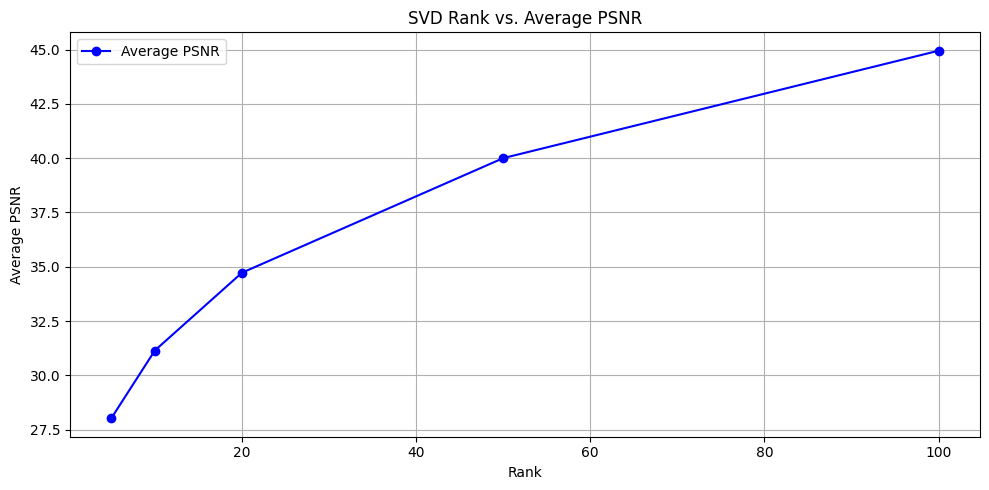

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compute_psnr

# Image paths
image_paths = [
    "/content/train/train/00a76543ed93_4a223cccbe04_ad8d4a5ba8f0.jpg",
    "/content/train/train/00c83e33588f_2892280fbaaf_7e7d3afebf5d.jpg",
    "/content/train/train/01e19055f756_4c636dbb3aa1_f782a61c168f.jpg",
    "/content/train/train/03db5dc7f1a2_892569f699eb_ff322f8e36c4.jpg",
    "/content/train/train/0a54c691d360_28edc5f0664d_1311dd6f5c2e.jpg"
]

# SVD ranks to evaluate
ranks_to_test = [5, 10, 20, 50, 100]


def load_grayscale_image(path):
    """Loads an image in grayscale mode."""
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    return image


def apply_svd_compression(image, rank):
    """Applies low-rank approximation using SVD."""
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    S[rank:] = 0
    compressed = U @ np.diag(S) @ Vt
    return np.clip(compressed, 0, 255).astype(np.uint8)


def evaluate_images_with_svd(image_paths, ranks):
    """Processes images and returns PSNR results per rank."""
    psnr_by_rank = {rank: [] for rank in ranks}
    for path in image_paths:
        original = load_grayscale_image(path)
        for rank in ranks:
            compressed = apply_svd_compression(original, rank)
            psnr_value = compute_psnr(original, compressed, data_range=original.max() - original.min())
            psnr_by_rank[rank].append(psnr_value)
    return psnr_by_rank


def plot_psnr_results(psnr_data):
    """Plots average PSNR values for different SVD ranks."""
    avg_psnr = {rank: np.mean(scores) for rank, scores in psnr_data.items()}
    plt.figure(figsize=(10, 5))
    plt.plot(list(avg_psnr.keys()), list(avg_psnr.values()), marker='o', color='b', label='Average PSNR')
    plt.title('SVD Rank vs. Average PSNR')
    plt.xlabel('Rank')
    plt.ylabel('Average PSNR')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Run evaluation and plot results
psnr_results = evaluate_images_with_svd(image_paths, ranks_to_test)
plot_psnr_results(psnr_results)


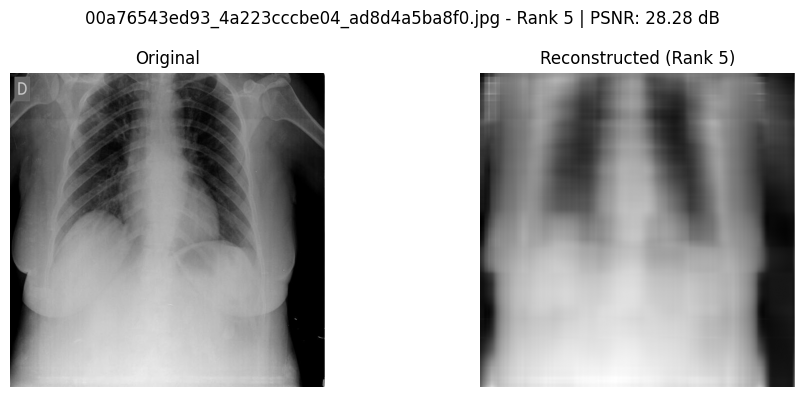

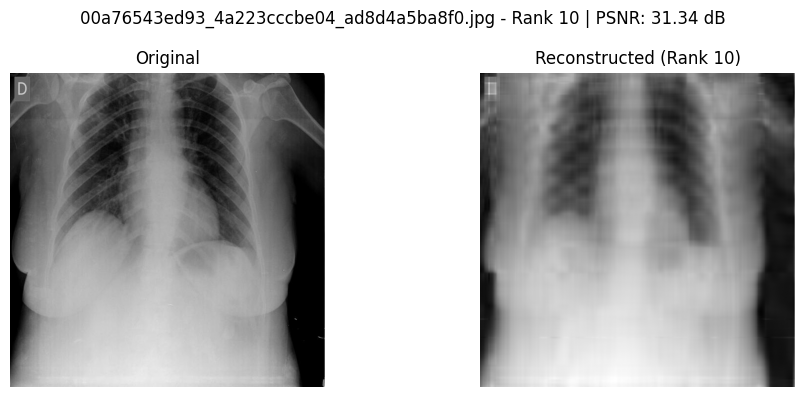

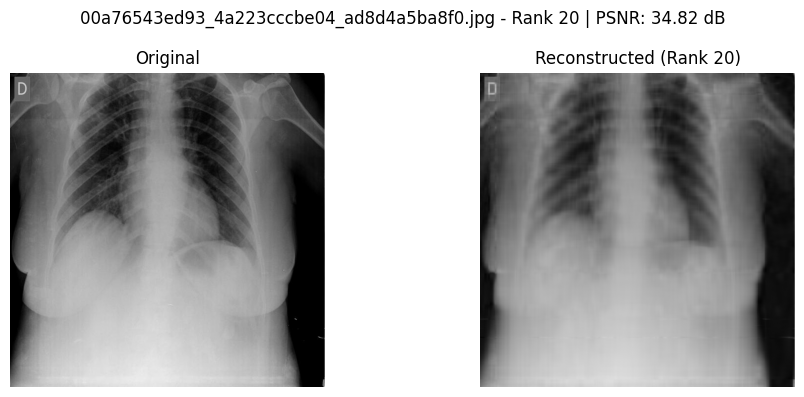

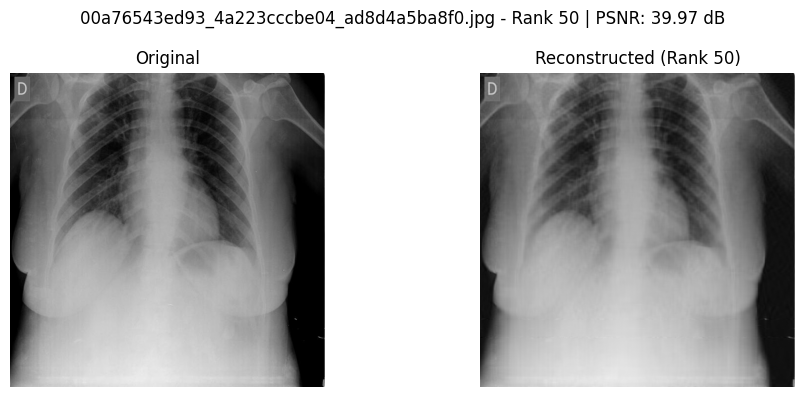

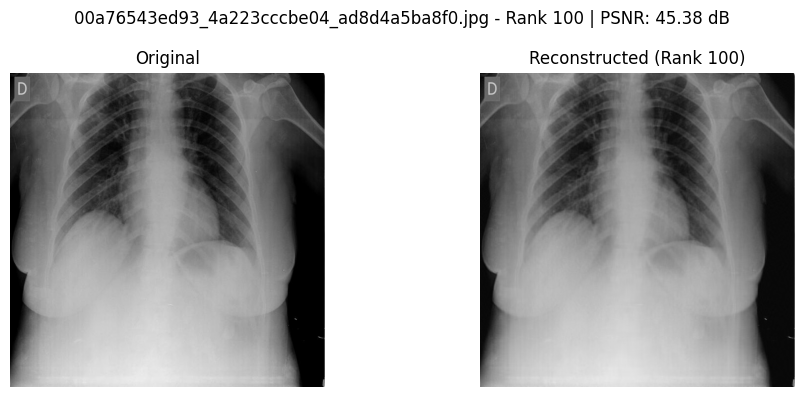

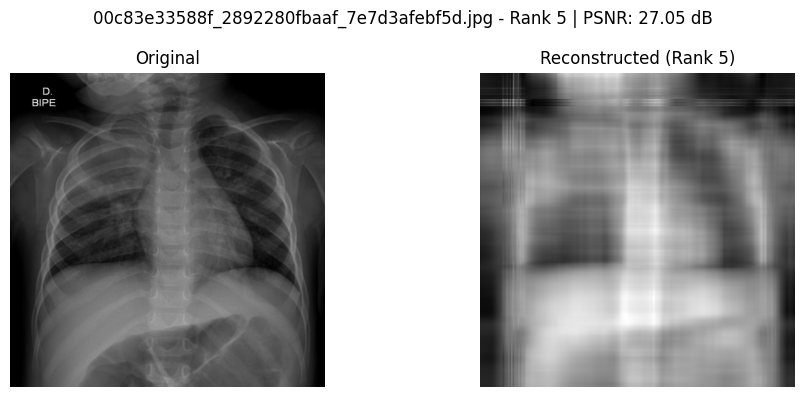

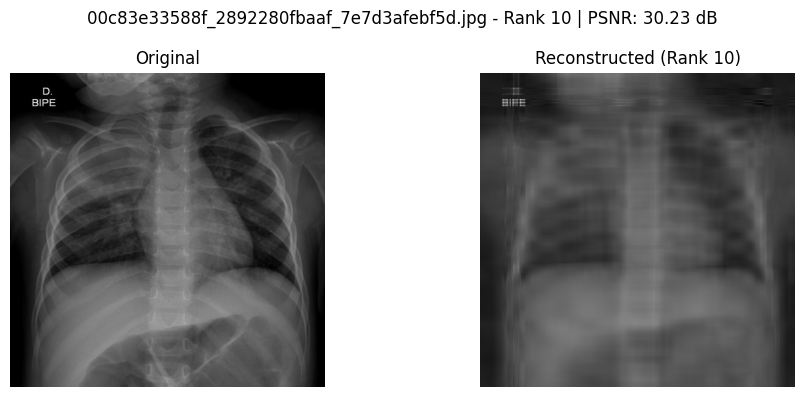

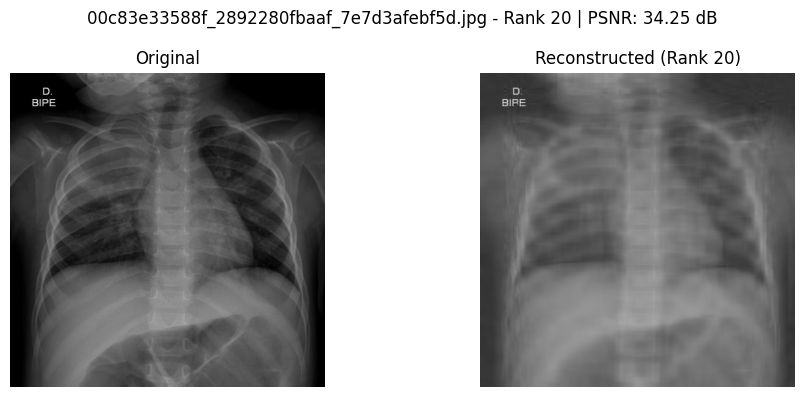

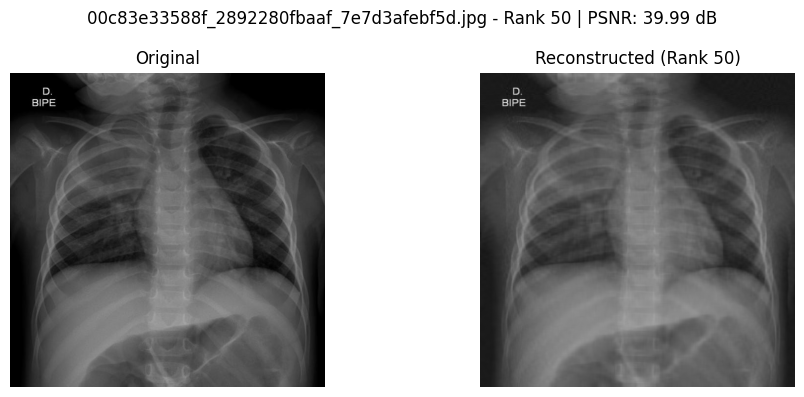

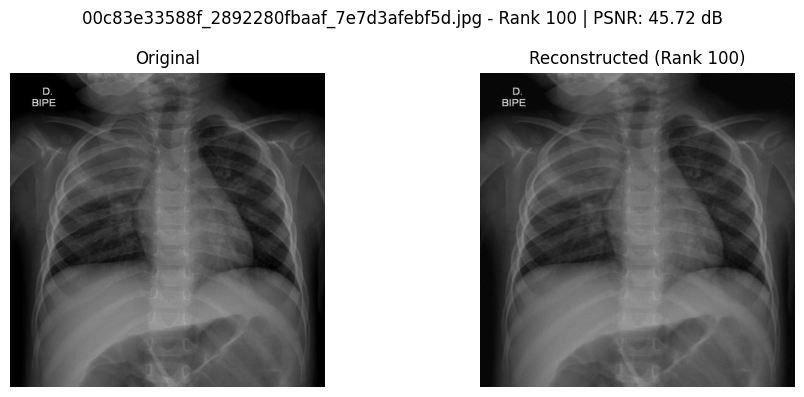

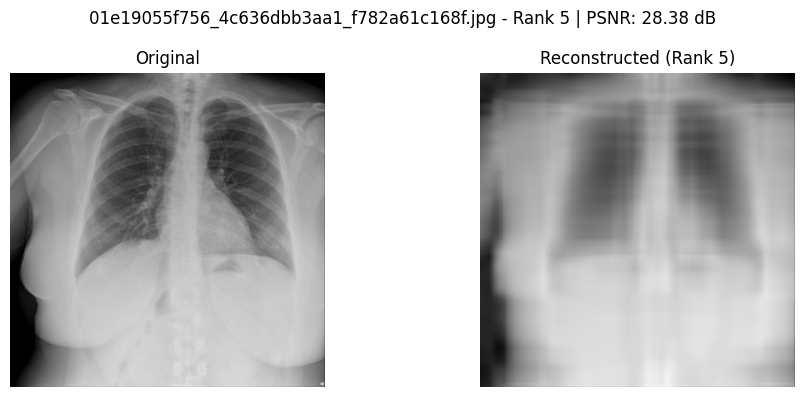

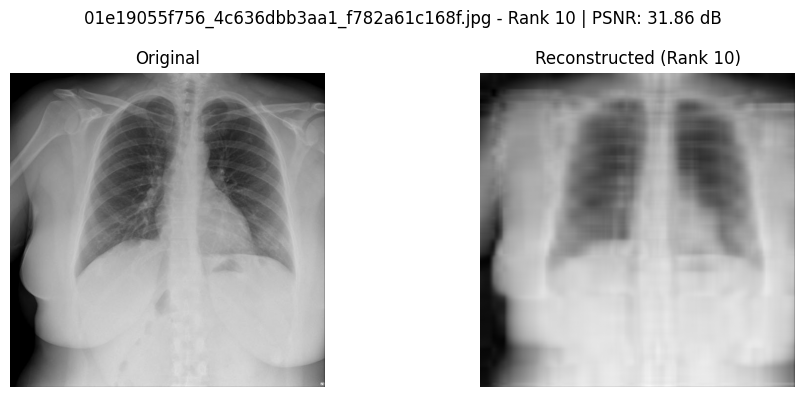

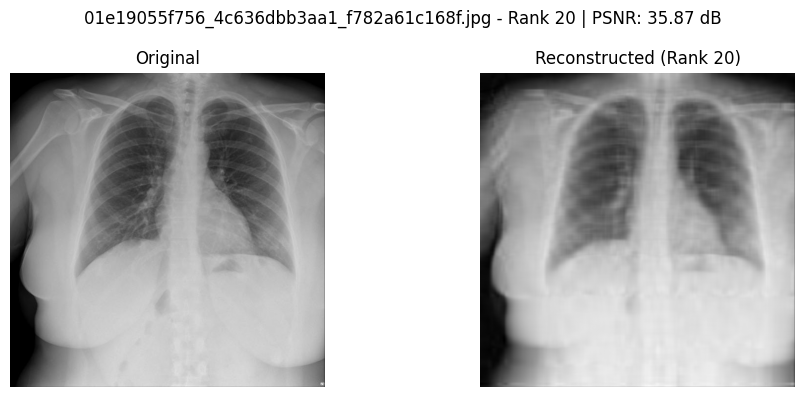

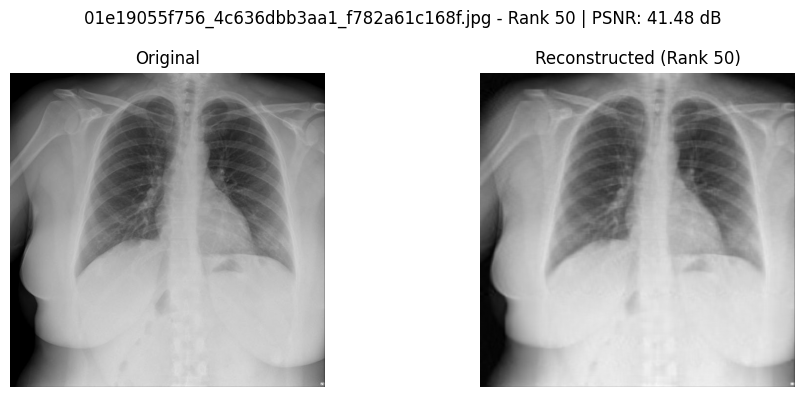

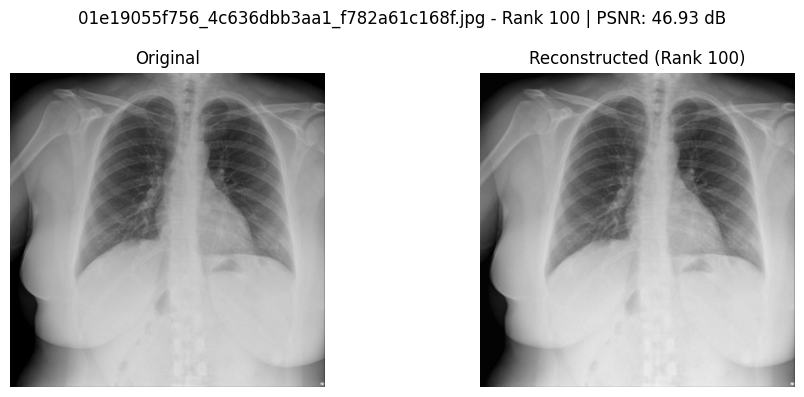

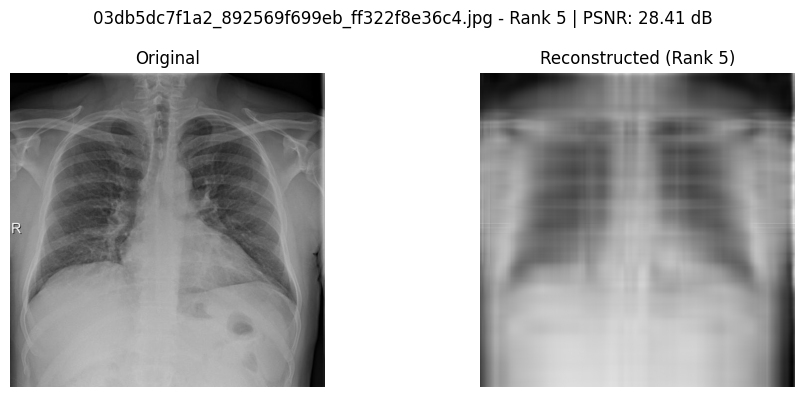

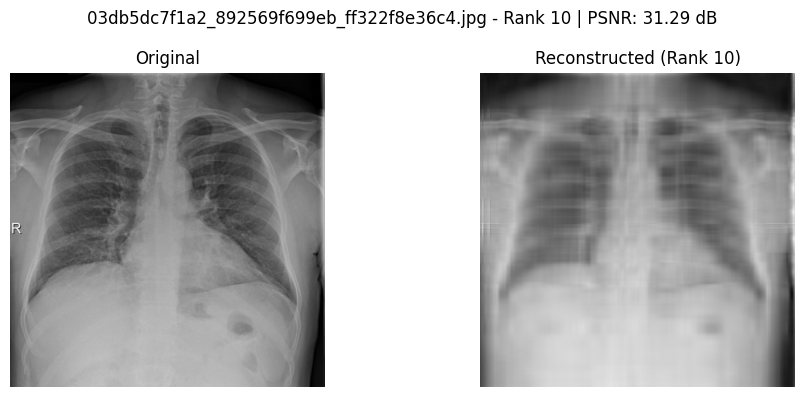

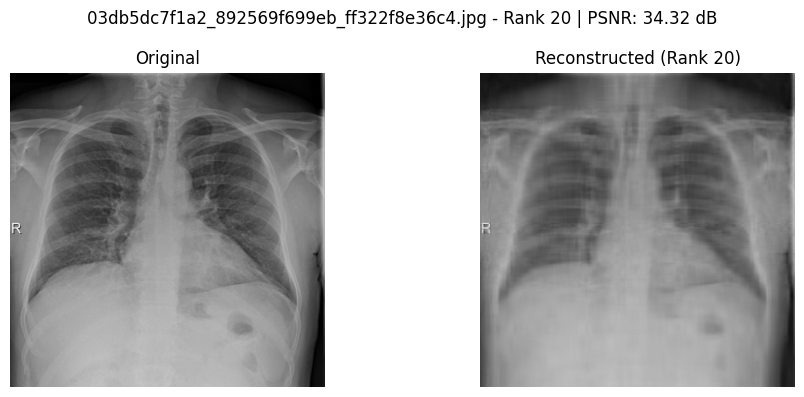

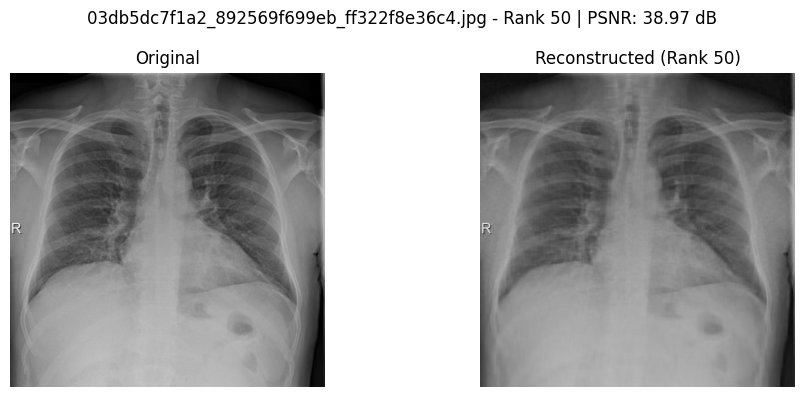

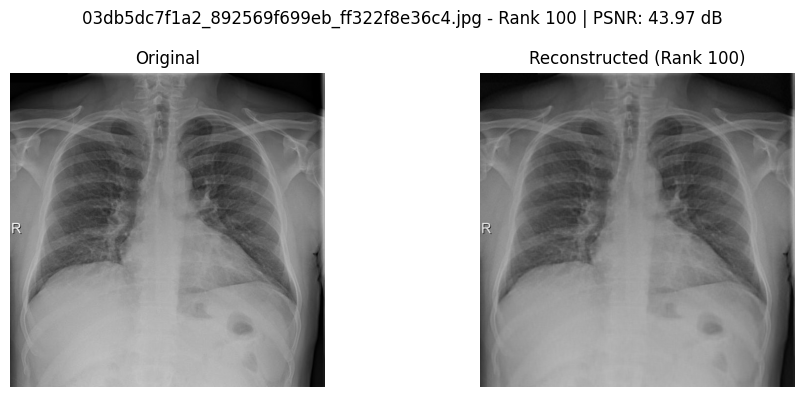

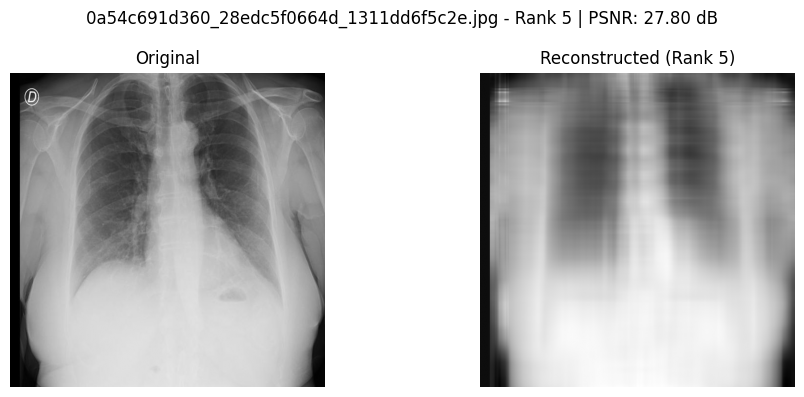

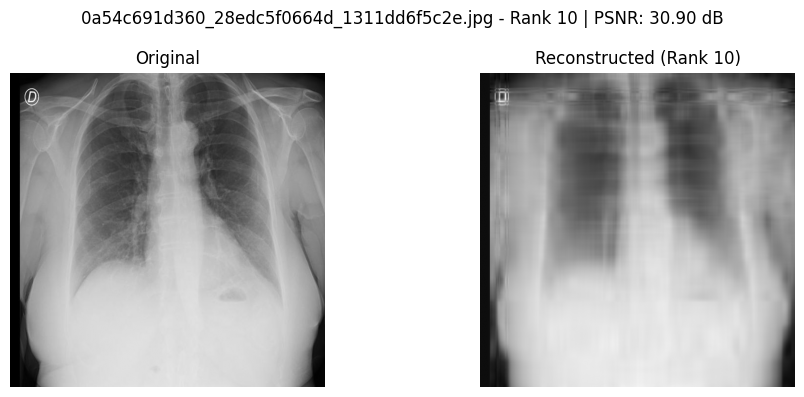

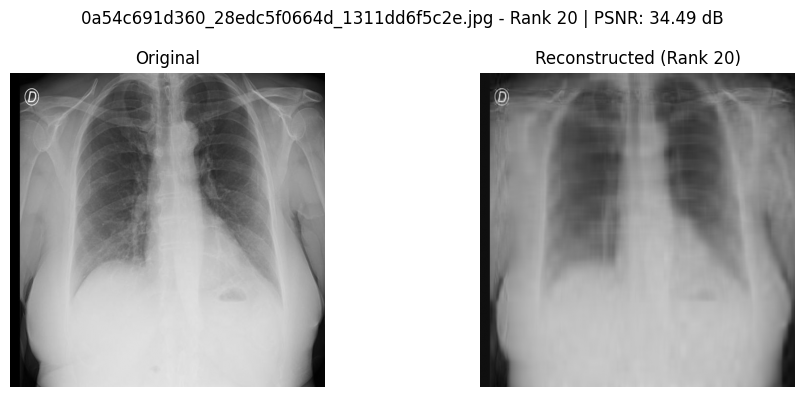

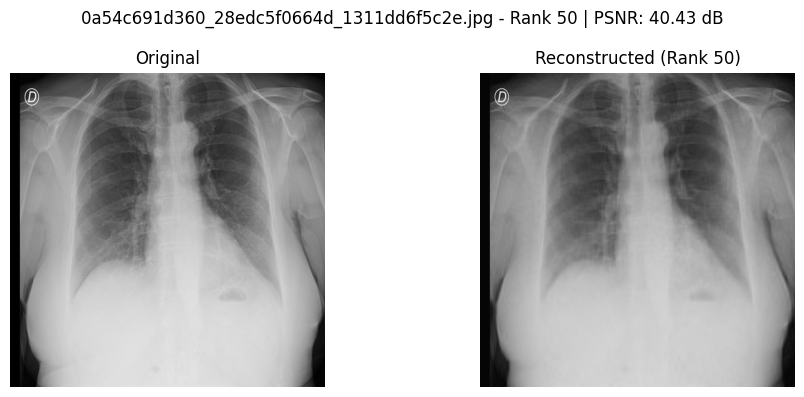

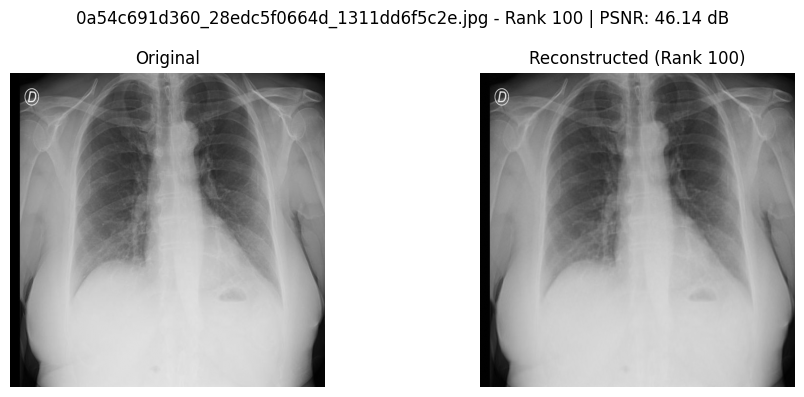

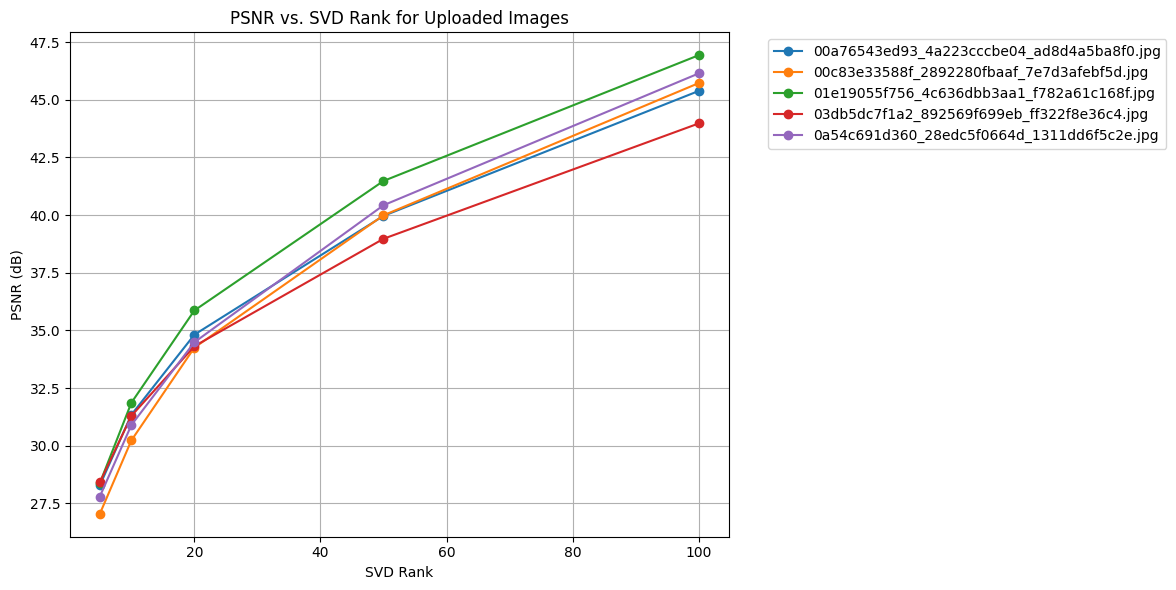

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compute_psnr

# Image paths
image_paths = [
    "/content/train/train/00a76543ed93_4a223cccbe04_ad8d4a5ba8f0.jpg",
    "/content/train/train/00c83e33588f_2892280fbaaf_7e7d3afebf5d.jpg",
    "/content/train/train/01e19055f756_4c636dbb3aa1_f782a61c168f.jpg",
    "/content/train/train/03db5dc7f1a2_892569f699eb_ff322f8e36c4.jpg",
    "/content/train/train/0a54c691d360_28edc5f0664d_1311dd6f5c2e.jpg"
]

# Ranks to test
ranks = [5, 10, 20, 50, 100]

def load_image_grayscale(path):
    """Loads an image as grayscale and converts to float32."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img.astype(np.float32)

def svd_reconstruct(image, rank):
    """Reconstructs the image using SVD with a given rank."""
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    S_reduced = np.diag(S[:rank])
    return U[:, :rank] @ S_reduced @ Vt[:rank, :]

def process_images(image_paths, ranks):
    """Processes each image with SVD and computes PSNR values."""
    psnr_results = {}

    for path in image_paths:
        image = load_image_grayscale(path)
        img_name = path.split('/')[-1]
        psnr_results[img_name] = []

        for rank in ranks:
            reconstructed = svd_reconstruct(image, rank)
            psnr_value = compute_psnr(image, reconstructed, data_range=image.max() - image.min())
            psnr_results[img_name].append(psnr_value)

            # Show side-by-side comparison for each rank
            show_image_comparison(image, reconstructed, img_name, rank, psnr_value)

    return psnr_results

def show_image_comparison(original, reconstructed, title, rank, psnr_value):
    """Displays original and reconstructed images side by side."""
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{title} - Rank {rank} | PSNR: {psnr_value:.2f} dB", fontsize=12)

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f"Reconstructed (Rank {rank})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def plot_psnr_vs_rank(psnr_data, ranks):
    """Plots PSNR vs SVD rank for all images."""
    plt.figure(figsize=(12, 6))
    for img_name, psnr_list in psnr_data.items():
        plt.plot(ranks, psnr_list, marker='o', label=img_name)

    plt.title("PSNR vs. SVD Rank for Uploaded Images")
    plt.xlabel("SVD Rank")
    plt.ylabel("PSNR (dB)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run the SVD compression and evaluation
psnr_data = process_images(image_paths, ranks)
plot_psnr_vs_rank(psnr_data, ranks)
